In [8]:
#import necessary libraries

import pandas as pd
import numpy as np
import nltk
from nltk.corpus import treebank
from nltk.corpus import brown
from nltk.corpus import conll2000
nltk.download('treebank')
nltk.download('brown')
nltk.download('conll2000')
nltk.download('universal_tagset')

[nltk_data] Downloading package treebank to
[nltk_data]     /Users/vp054179/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package brown to /Users/vp054179/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/vp054179/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/vp054179/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [78]:
from keras.preprocessing.text import Tokenizer
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from gensim.models import KeyedVectors
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.layers import TimeDistributed

### Load Data

In [47]:
#load POS tagged corpora from nltk
treebank_corpus = treebank.tagged_sents(tagset = 'universal')
brown_corpus = brown.tagged_sents(tagset='universal')
conll_corpus = conll2000.tagged_sents(tagset='universal')

tagged_sentences = treebank_corpus + brown_corpus + conll_corpus

In [48]:
# let's look at the data
tagged_sentences[7]

[('A', 'DET'),
 ('Lorillard', 'NOUN'),
 ('spokewoman', 'NOUN'),
 ('said', 'VERB'),
 (',', '.'),
 ('``', '.'),
 ('This', 'DET'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('old', 'ADJ'),
 ('story', 'NOUN'),
 ('.', '.')]

### Divide data in words (X) and tags (Y)

In [49]:
X = [] # store input sequence
Y = [] # store output sequence

for sentence in tagged_sentences:
    X_sentence = []
    Y_sentence = []
    for entity in sentence: 
        X_sentence.append(entity[0]) # entity[0] contains the word
        Y_sentence.append(entity[1])  # entity[1] contains corresponding tag
        
    X.append(X_sentence)
    Y.append(Y_sentence)
   


In [50]:
num_words = len(set([word.lower() for sentence in X for word in sentence]))
num_tags   = len(set([word.lower() for sentence in Y for word in sentence]))

In [51]:
print("Total number of tagged sentences: {}".format(len(X)))
print("Vocabulary size: {}".format(num_words))
print("Total number of tags: {}".format(num_tags))

Total number of tagged sentences: 72202
Vocabulary size: 59448
Total number of tags: 12


In [52]:
# let's look at first data point
# this is one data point that will be fed to the RNN
print('sample X: ', X[0], '\n')
print('sample Y: ', Y[0], '\n')

sample X:  ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.'] 

sample Y:  ['NOUN', 'NOUN', '.', 'NUM', 'NOUN', 'ADJ', '.', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'NUM', '.'] 



In [53]:
# In this many-to-many problem, the length of each input and output sequence must be the same.
# Since each word is tagged, it's important to make sure that the length of input sequence equals the output sequence
print("Length of first input sequence  : {}".format(len(X[0])))
print("Length of first output sequence : {}".format(len(Y[0])))

Length of first input sequence  : 18
Length of first output sequence : 18


### Vectorise X and Y

In [54]:
# encode X

word_tokenizer = Tokenizer()                      # instantiate tokeniser
word_tokenizer.fit_on_texts(X)                    # fit tokeniser on data
X_encoded = word_tokenizer.texts_to_sequences(X)  # use the tokeniser to encode input sequence

In [55]:
# encode Y

tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y)
Y_encoded = tag_tokenizer.texts_to_sequences(Y)

In [56]:
# look at first encoded data point

print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', X[0], '\n')
print('Y: ', Y[0], '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', X_encoded[0], '\n')
print('Y: ', Y_encoded[0], '\n')

** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.'] 

Y:  ['NOUN', 'NOUN', '.', 'NUM', 'NOUN', 'ADJ', '.', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'NUM', '.'] 


** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [6423, 24231, 2, 7652, 102, 170, 2, 47, 1898, 1, 269, 17, 7, 13230, 619, 1711, 2761, 3] 

Y:  [1, 1, 3, 11, 1, 6, 3, 2, 2, 5, 1, 4, 5, 6, 1, 1, 11, 3] 



In [57]:
# make sure that each sequence of input and output is same length

different_length = [1 if len(x) != len(y) else 0 for x, y in zip(X_encoded, Y_encoded)]
print("{} sentences have disparate input-output lengths.".format(sum(different_length)))

0 sentences have disparate input-output lengths.


### Pad sequences

In [58]:
# check length of longest sentence
lengths = [len(seq) for seq in X_encoded]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 271


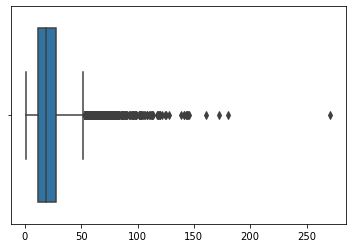

In [59]:
sns.boxplot(lengths)
plt.show()

In [60]:
# Pad each sequence to MAX_SEQ_LENGTH using KERAS' pad_sequences() function. 
# Sentences longer than MAX_SEQ_LENGTH are truncated.
# Sentences shorter than MAX_SEQ_LENGTH are padded with zeroes.

# Truncation and padding can either be 'pre' or 'post'. 
# For padding we are using 'pre' padding type, that is, add zeroes on the left side.
# For truncation, we are using 'post', that is, truncate a sentence from right side.

MAX_SEQ_LENGTH = 100  # sequences greater than 100 in length will be truncated

X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

In [61]:
# print the first sequence
print(X_padded[0], "\n"*3)
print(Y_padded[0])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0  6423 24231
     2  7652   102   170     2    47  1898     1   269    17     7 13230
   619  1711  2761     3] 



[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  1  1  3 11  1  6  3  2  2  5  1  4  5  6
  1  1 11  3]


In [62]:
# assign padded sequences to X and Y
X, Y = X_padded, Y_padded

### Use word embeddings for input sequences (X)

In [ ]:
# # word2vec

# path = '../input/wordembeddings/GoogleNews-vectors-negative300.bin'


# # load word2vec using the following function present in the gensim library
# word2vec = KeyedVectors.load_word2vec_format(path, binary=True)

In [76]:
# # assign word vectors from word2vec model

EMBEDDING_SIZE  = 300  # each word in word2vec model is represented using a 300 dimensional vector
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

# # create an empty embedding matix
# embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# # create a word to index dictionary mapping
# word2id = word_tokenizer.word_index

# # copy vectors from word2vec model to the words present in corpus
# for word, index in word2id.items():
#     try:
#         embedding_weights[index, :] = word2vec[word]
#     except KeyError:
#         pass

In [ ]:
# # check embedding dimension
# print("Embeddings shape: {}".format(embedding_weights.shape))

In [ ]:
# # let's look at an embedding of a word
# embedding_weights[word_tokenizer.word_index['joy']]

### Use one-hot encoding for output sequences (Y)

In [67]:
# use Keras' to_categorical function to one-hot encode Y
Y = to_categorical(Y)

In [68]:
# print Y of the first output sequqnce
print(Y.shape)

(72202, 100, 13)


### Split data in training, validation and tesing sets

In [69]:
# split entire data into training and testing sets
TEST_SIZE = 0.15
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=4)

In [70]:
# split training data into training and validation sets
VALID_SIZE = 0.15
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=VALID_SIZE, random_state=4)



In [71]:
# print number of samples in each set
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_validation.shape))
print('Shape of output sequences: {}'.format(Y_validation.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(Y_test.shape))

TRAINING DATA
Shape of input sequences: (52165, 100)
Shape of output sequences: (52165, 100, 13)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (9206, 100)
Shape of output sequences: (9206, 100, 13)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (10831, 100)
Shape of output sequences: (10831, 100, 13)


### 2. Vanilla RNN

In [72]:
# total number of tags
NUM_CLASSES = Y.shape[2]

**First let's try running a vanilla RNN. For this RNN we won't use the pre-trained word embeddings. We'll use randomly inititalised embeddings. Moreover, we won't update the embeddings weights.**

In [83]:
# create architecture

rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        trainable     =  False                    # False - don't update the embeddings
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))
rnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 100, 64)           23360     
                                                                 
 time_distributed_1 (TimeDis  (None, 100, 13)          845       
 tributed)                                                       
                                                                 
Total params: 17,858,905
Trainable params: 24,205
Non-trainable params: 17,834,700
_________________________________________________________________


In [84]:
VOCABULARY_SIZE

59449

### compile model

In [80]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])


In [81]:
# check summary of the model
rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100, 64)           23360     
                                                                 
 time_distributed (TimeDistr  (None, 100, 13)          845       
 ibuted)                                                         
                                                                 
Total params: 17,858,905
Trainable params: 24,205
Non-trainable params: 17,834,700
_________________________________________________________________


### Fit model

In [82]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))


Epoch 1/10
408/408 [==============================] - 14s 33ms/step - loss: 0.5137 - acc: 0.8505 - val_loss: 0.3380 - val_acc: 0.8967
Epoch 2/10
408/408 [==============================] - 13s 32ms/step - loss: 0.2813 - acc: 0.9131 - val_loss: 0.2357 - val_acc: 0.9277
Epoch 3/10
408/408 [==============================] - 14s 33ms/step - loss: 0.2131 - acc: 0.9335 - val_loss: 0.1922 - val_acc: 0.9388
Epoch 4/10
408/408 [==============================] - 13s 32ms/step - loss: 0.1804 - acc: 0.9420 - val_loss: 0.1675 - val_acc: 0.9456
Epoch 5/10
408/408 [==============================] - 13s 32ms/step - loss: 0.1598 - acc: 0.9481 - val_loss: 0.1506 - val_acc: 0.9511
Epoch 6/10
408/408 [==============================] - 14s 33ms/step - loss: 0.1463 - acc: 0.9523 - val_loss: 0.1399 - val_acc: 0.9538
Epoch 7/10
408/408 [==============================] - 14s 33ms/step - loss: 0.1375 - acc: 0.9546 - val_loss: 0.1327 - val_acc: 0.9558
Epoch 8/10
408/408 [==============================] - 14s 33ms

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

from matplotlib import pyplot as plt

from nltk.corpus import brown
from nltk.corpus import treebank
from nltk.corpus import conll2000

import seaborn as sns

from gensim.models import KeyedVectors

from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical




from keras.models import Model
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
